### Google Stock Price Prediction

#### 1. Fire the System

In [20]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

#### 2. Read Data

In [21]:
# importing train data

dataset_train = pd.read_csv('GOOG.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [22]:
dataset_train.shape

(4006, 7)

In [23]:
dataset_train.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [24]:
dataset_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [25]:
# selecting features for training and predictions

cols = list(dataset_train)[1:6]

# extract dates (will be used in visualization)

datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print(f'Training set shape: {dataset_train.shape}')
print(f'All Timestamps: {len(datelist_train)}')
print(f'Selected Features: {cols}')

Training set shape: (4006, 7)
All Timestamps: 4006
Selected Features: ['Open', 'High', 'Low', 'Close', 'Adj Close']


#### 3. Data Pre-processing

In [26]:
# removing all the commas and converting data to matrix shape format

dataset_train = dataset_train[cols].astype(str)

for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',','')

dataset_train = dataset_train.astype(float)

# using multiple features (predictors)
training_set = dataset_train.to_numpy()

print(f'Shape of training set : {training_set.shape}')
training_set

Shape of training set : (4006, 5)


array([[  49.813286,   51.835709,   47.800831,   49.982655,   49.982655],
       [  50.316402,   54.336334,   50.062355,   53.95277 ,   53.95277 ],
       [  55.168217,   56.528118,   54.321388,   54.495735,   54.495735],
       ...,
       [1523.130005, 1535.329956, 1498.      , 1513.640015, 1513.640015],
       [1500.      , 1518.689941, 1486.310059, 1518.      , 1518.      ],
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049]])

In [27]:
# feature scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])


array([[-1.27195197],
       [-1.27058974],
       [-1.25745309],
       ...,
       [ 2.71716347],
       [ 2.65453724],
       [ 2.713075  ]])

In [28]:
# creating a data structure with 90 timestamps and 1 output

x_train = []
y_train = []

n_past = 90 #number of past days we need to predict the future
n_future = 60 #number of days we need to predict into the future

for i in range(n_past,len(training_set_scaled) - n_future + 1):
    x_train.append(training_set_scaled[i-n_past:i,0:dataset_train.shape[1]-1])
    y_train.append(training_set_scaled[i+n_future-1:i+n_future,0])

x_train,y_train = np.array(x_train),np.array(y_train)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')



x_train shape: (3857, 90, 4)
y_train shape: (3857, 1)


#### Create a model and training

##### Building the LSTM based Neural network

In [29]:
# importing libraries and packages from keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [30]:
# model building

model = Sequential()
model.add(LSTM(units = 64,
               return_sequences=True,
               input_shape = (n_past,dataset_train.shape[1]-1)))
model.add(LSTM(units = 10,
          return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(units=1,
                activation = 'linear'))
model.compile(optimizer = Adam(learning_rate=0.01),
              loss = 'mean_squared_error')

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
#training

es = EarlyStopping(monitor = 'val_loss',min_delta=1e-10,patience=10,verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1)
mcp = ModelCheckpoint(filepath='weights.weights.h5',monitor='val_loss',verbose=1,
save_best_only=True,save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train,y_train,shuffle=True,epochs = 30,callbacks=[es,rlr,mcp,tb],
validation_split=0.2,verbose =1, batch_size=256)

Epoch 1/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1950
Epoch 1: val_loss improved from inf to 1.65711, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - loss: 0.1812 - val_loss: 1.6571 - learning_rate: 0.0100
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0387
Epoch 2: val_loss improved from 1.65711 to 0.26142, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.0385 - val_loss: 0.2614 - learning_rate: 0.0100
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0313
Epoch 3: val_loss improved from 0.26142 to 0.17393, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0313 - val_loss: 0.1739 - learning_rate: 0.0100
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0303
Epoch 4: val_loss did not improve from 0.17393
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.0303 - val_loss: 0.2374 - learning_rate: 0.0100
Epoch 5/30
13/13 ━━━━━━━━━━━━━━

#### Make future predictions

In [32]:
# Generate list of sequence of days for predictions

datelist_future = pd.date_range(datelist_train[-1],periods = n_future,freq = '1d').tolist()

# convert pandas Timestamp to Datetime object (for transformation) --> Future

datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

#### Make predictions for future dates

In [33]:
# perform predictions

predictions_future = model.predict(x_train[-n_future:])
predictions_train = model.predict(x_train[n_past:])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [35]:
# inverse the predictions to original measurements

#---> Special function: convert <datetime.date> to <Timestamp>

def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

Predictions_future_ = pd.DataFrame(y_pred_future,columns = ['Open']).set_index(pd.Series(datelist_future))
Prediction_train_ = pd.DataFrame(y_pred_train,columns = ['Open']).set_index(pd.Series(datelist_train[2*n_past + n_future-1:]))

# convert <datetime.date> to <Timestamp> for prediction train

Prediction_train_.index = Prediction_train_.index.to_series().apply(datetime_to_timestamp)

Prediction_train_.head()

,Open
2005-08-01,168.447891
2005-08-02,169.036911
2005-08-03,169.439499
2005-08-04,169.679947
2005-08-05,169.999924


#### Visualizing Predictions

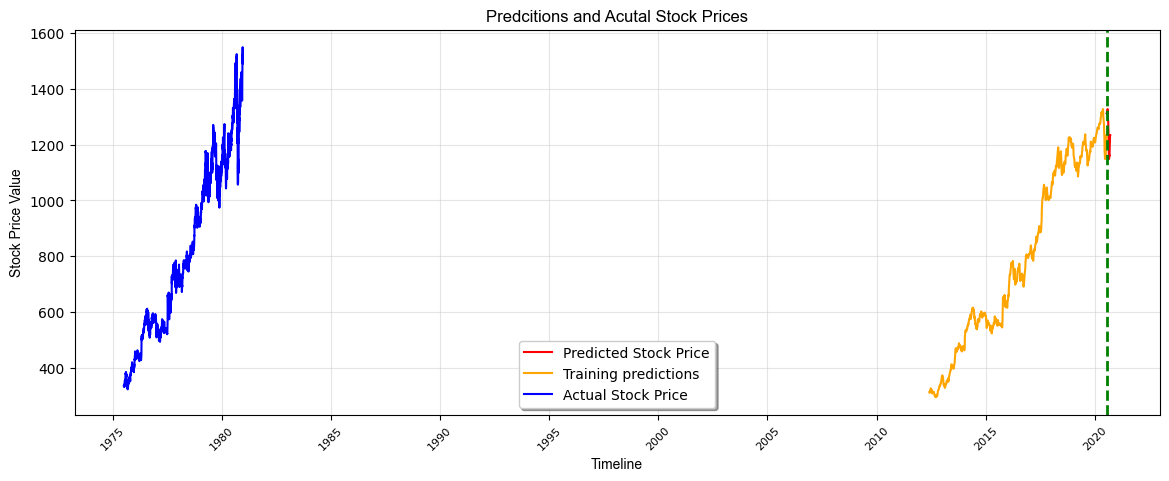

In [37]:

# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(Predictions_future_.index, Predictions_future_['Open'], color='r', label='Predicted Stock Price')
plt.plot(Prediction_train_.loc[START_DATE_FOR_PLOTTING:].index, Prediction_train_.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(Predictions_future_.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()